In [1]:
pcap_file = "./datatest2/codel1_ecn.em1.pcap"

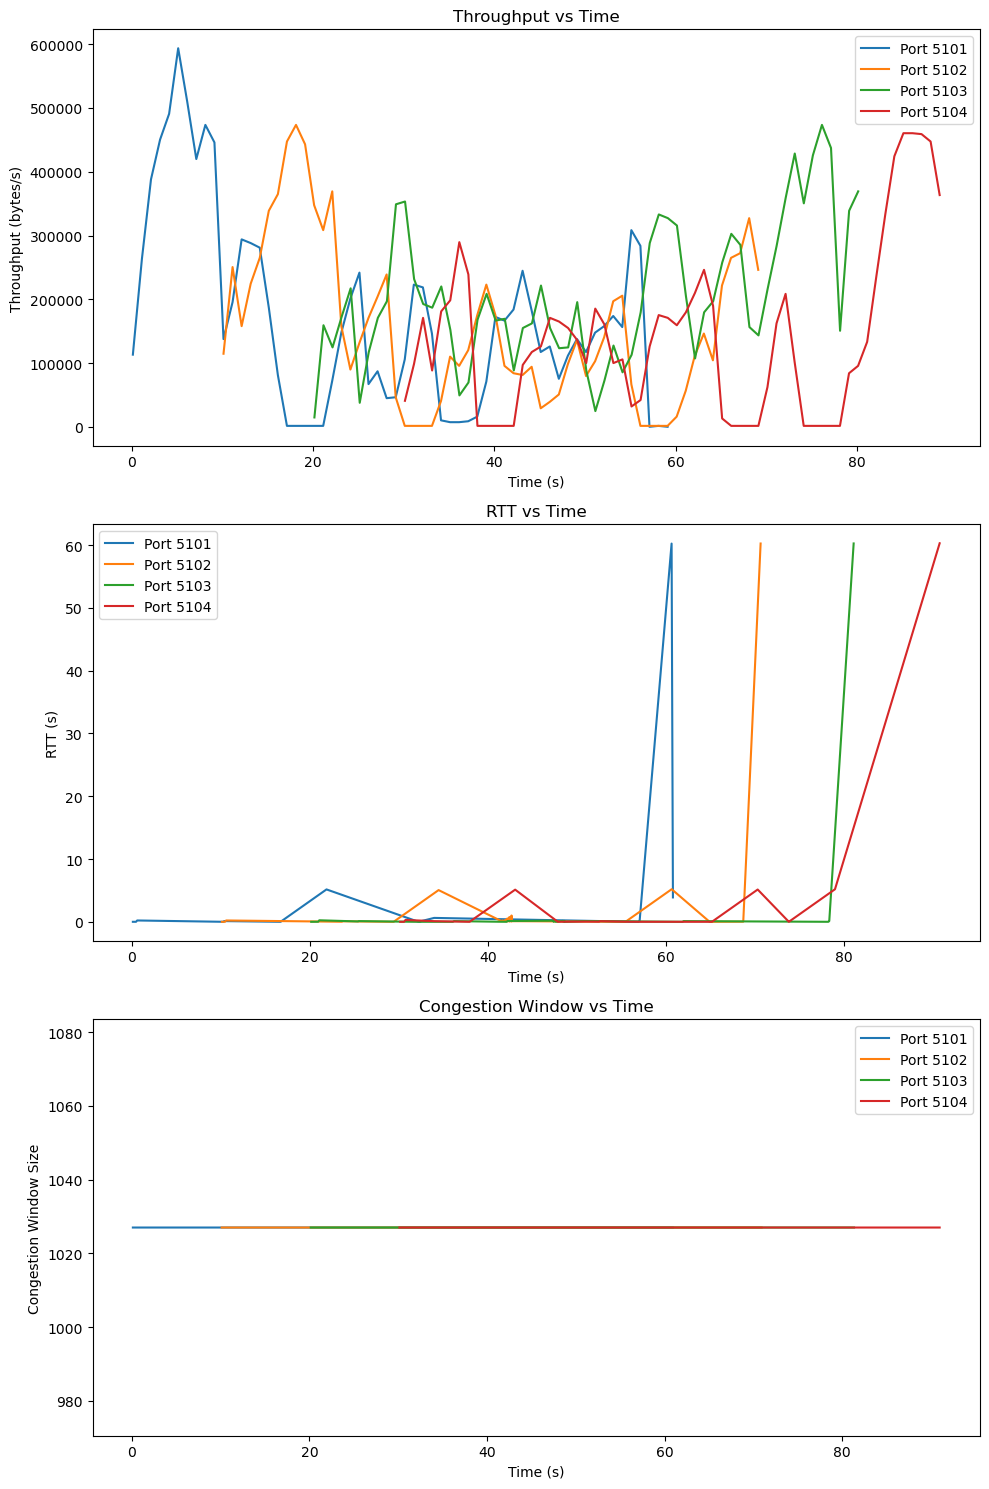

In [2]:
import dpkt
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_pcap(file_path, ports):
    data = defaultdict(list)
    
    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if isinstance(eth.data, dpkt.ip.IP):
                ip = eth.data
                if isinstance(ip.data, dpkt.tcp.TCP):
                    tcp = ip.data
                    src_port = tcp.sport
                    dst_port = tcp.dport
                    seq_num = tcp.seq
                    ack_num = tcp.ack
                    window_size = tcp.win
                    length = len(tcp.data)
                    
                    if dst_port in ports:
                        data[dst_port].append({
                            'timestamp': timestamp,
                            'src_port': src_port,
                            'dst_port': dst_port,
                            'seq_num': seq_num,
                            'ack_num': ack_num,
                            'window_size': window_size,
                            'length': length
                        })
    return data

# Normalize timestamps so that each port starts at 0, 10, 20, and 30 seconds respectively
def normalize_timestamps(data, ports, start_times):
    for port, start_time in zip(ports, start_times):
        port_packets = data[port]
        if port_packets:
            first_timestamp = port_packets[0]['timestamp']
            for packet in port_packets:
                packet['timestamp'] -= first_timestamp
                packet['timestamp'] += start_time
    return data

def calculate_throughput(data, interval=1.0):
    throughput = defaultdict(list)
    
    for port, packets in data.items():
        packets.sort(key=lambda x: x['timestamp'])
        current_interval = packets[0]['timestamp']
        bytes_transferred = 0
        
        for packet in packets:
            if packet['timestamp'] <= current_interval + interval:
                bytes_transferred += packet['length']
            else:
                throughput[port].append((current_interval, bytes_transferred / interval))
                current_interval += interval
                bytes_transferred = packet['length']
                
    return throughput

def calculate_rtt(data):
    rtt = defaultdict(list)
    sent_packets = {}
    
    for port, packets in data.items():
        for packet in packets:
            key = (packet['src_port'], packet['seq_num'])
            if key not in sent_packets:
                sent_packets[key] = packet['timestamp']
            else:
                rtt_value = packet['timestamp'] - sent_packets[key]
                rtt[port].append((packet['timestamp'], rtt_value))
                
    return rtt

# Function to filter out outliers using IQR method
def filter_outliers_iqr(data):
    filtered_data = defaultdict(list)
    
    for port, packets in data.items():
        window_sizes = [pkt['window_size'] for pkt in packets]
        q1 = np.percentile(window_sizes, 25)
        q3 = np.percentile(window_sizes, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        for packet in packets:
            if lower_bound <= packet['window_size'] <= upper_bound:
                filtered_data[port].append(packet)
                
    return filtered_data

def plot_data(throughput, rtt, window_sizes, ports):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    for port in ports:
        if port in throughput:
            x, y = zip(*throughput[port])
            axs[0].plot(x, y, label=f'Port {port}')
        if port in rtt:
            x, y = zip(*rtt[port])
            axs[1].plot(x, y, label=f'Port {port}')
        if port in window_sizes:
            x, y = zip(*window_sizes[port])
            axs[2].plot(x, y, label=f'Port {port}')
    
    axs[0].set_title('Throughput vs Time')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Throughput (bytes/s)')
    axs[0].legend()

    axs[1].set_title('RTT vs Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('RTT (s)')
    axs[1].legend()

    axs[2].set_title('Congestion Window vs Time')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Congestion Window Size')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Main execution
file_path = pcap_file
ports = [5101, 5102, 5103, 5104]
start_times = [0, 10, 20, 30]  # Adjust start times for each port

# Parse pcap file
data = parse_pcap(file_path, ports)

# Normalize timestamps
data = normalize_timestamps(data, ports, start_times)

# Filter out outliers
filtered_data = filter_outliers_iqr(data)

# Calculate metrics
throughput = calculate_throughput(filtered_data)
rtt = calculate_rtt(filtered_data)

# Extract window sizes
window_sizes = {port: [(pkt['timestamp'], pkt['window_size']) for pkt in pkts] for port, pkts in filtered_data.items()}

# Plot the data
plot_data(throughput, rtt, window_sizes, ports)


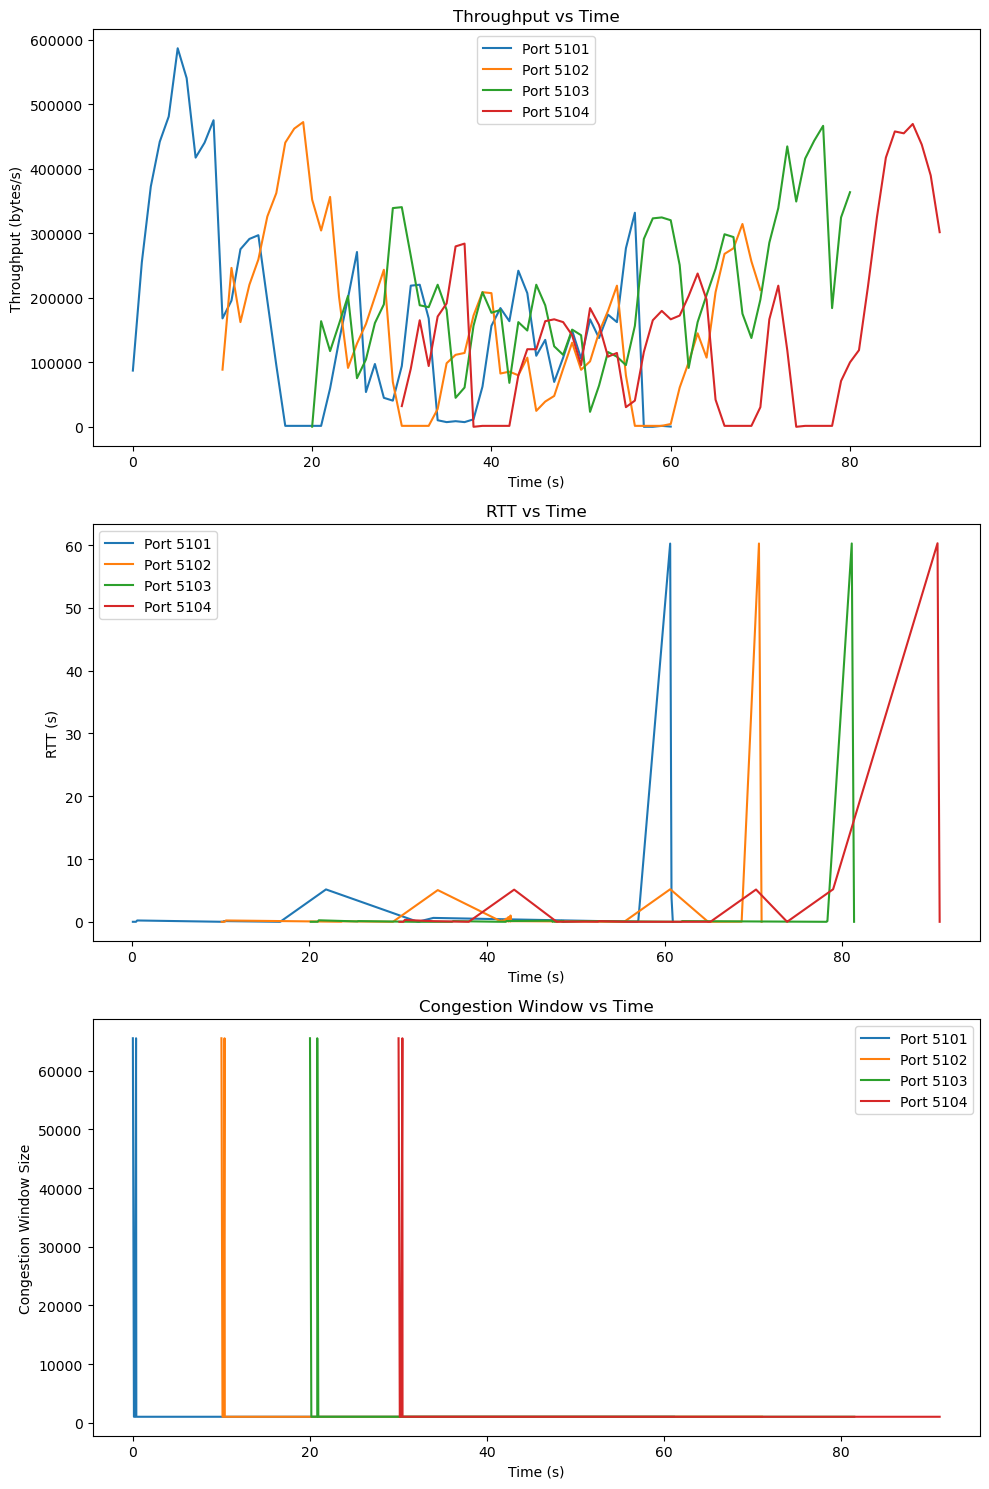

In [3]:
import dpkt
import socket
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to parse pcap file and extract data
def parse_pcap(file_path, ports):
    data = defaultdict(list)
    
    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if isinstance(eth.data, dpkt.ip.IP):
                ip = eth.data
                if isinstance(ip.data, dpkt.tcp.TCP):
                    tcp = ip.data
                    src_port = tcp.sport
                    dst_port = tcp.dport
                    seq_num = tcp.seq
                    ack_num = tcp.ack
                    window_size = tcp.win
                    length = len(tcp.data)
                    
                    if dst_port in ports:
                        data[dst_port].append({
                            'timestamp': timestamp,
                            'src_port': src_port,
                            'dst_port': dst_port,
                            'seq_num': seq_num,
                            'ack_num': ack_num,
                            'window_size': window_size,
                            'length': length
                        })
    return data

# Normalize timestamps so that each port starts at 0, 10, 20, and 30 seconds respectively
def normalize_timestamps(data, ports, start_times):
    for port, start_time in zip(ports, start_times):
        port_packets = data[port]
        if port_packets:
            first_timestamp = port_packets[0]['timestamp']
            for packet in port_packets:
                packet['timestamp'] -= first_timestamp
                packet['timestamp'] += start_time
    return data

def calculate_throughput(data, interval=1.0):
    throughput = defaultdict(list)
    
    for port, packets in data.items():
        packets.sort(key=lambda x: x['timestamp'])
        current_interval = packets[0]['timestamp']
        bytes_transferred = 0
        
        for packet in packets:
            if packet['timestamp'] <= current_interval + interval:
                bytes_transferred += packet['length']
            else:
                throughput[port].append((current_interval, bytes_transferred / interval))
                current_interval += interval
                bytes_transferred = packet['length']
                
    return throughput

def calculate_rtt(data):
    rtt = defaultdict(list)
    sent_packets = {}
    
    for port, packets in data.items():
        for packet in packets:
            key = (packet['src_port'], packet['seq_num'])
            if key not in sent_packets:
                sent_packets[key] = packet['timestamp']
            else:
                rtt_value = packet['timestamp'] - sent_packets[key]
                rtt[port].append((packet['timestamp'], rtt_value))
                
    return rtt

def plot_data(throughput, rtt, window_sizes, ports):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    for port in ports:
        if port in throughput:
            x, y = zip(*throughput[port])
            axs[0].plot(x, y, label=f'Port {port}')
        if port in rtt:
            x, y = zip(*rtt[port])
            axs[1].plot(x, y, label=f'Port {port}')
        if port in window_sizes:
            x, y = zip(*window_sizes[port])
            axs[2].plot(x, y, label=f'Port {port}')
    
    axs[0].set_title('Throughput vs Time')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Throughput (bytes/s)')
    axs[0].legend()

    axs[1].set_title('RTT vs Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('RTT (s)')
    axs[1].legend()

    axs[2].set_title('Congestion Window vs Time')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Congestion Window Size')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Main execution
file_path = pcap_file
ports = [5101, 5102, 5103, 5104]
start_times = [0, 10, 20, 30]  # Adjust start times for each port

# Parse pcap file
data = parse_pcap(file_path, ports)

# Normalize timestamps
data = normalize_timestamps(data, ports, start_times)

# Calculate metrics
throughput = calculate_throughput(data)
rtt = calculate_rtt(data)

# Extract window sizes
window_sizes = {port: [(pkt['timestamp'], pkt['window_size']) for pkt in pkts] for port, pkts in data.items()}

# Plot the data
plot_data(throughput, rtt, window_sizes, ports)


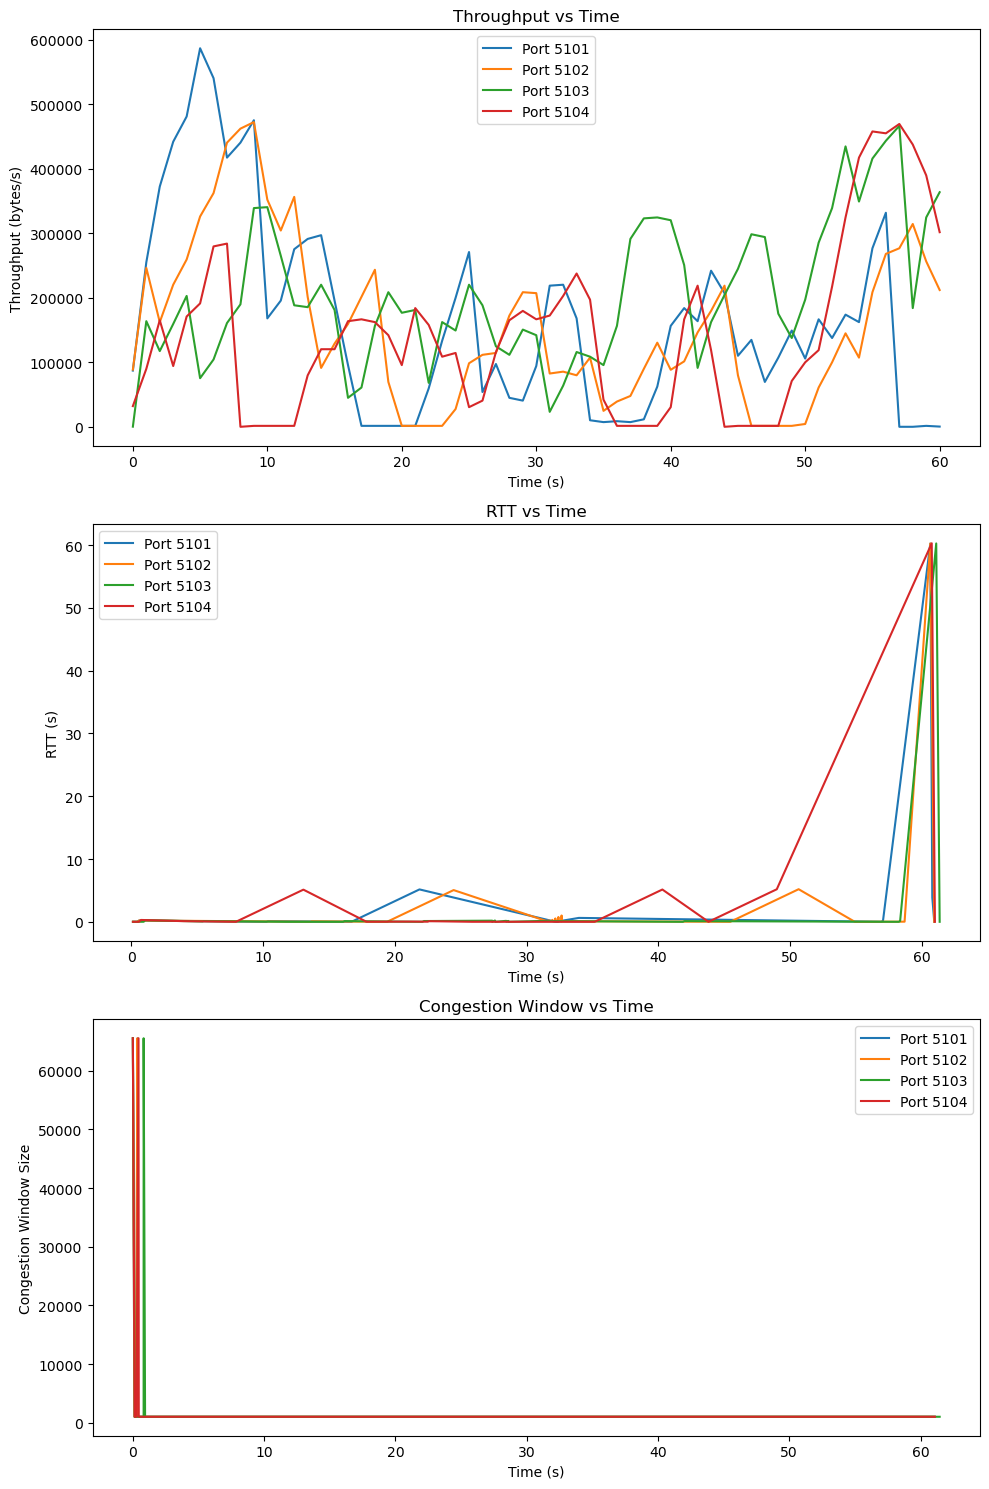

In [4]:
import dpkt
import socket
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_pcap(file_path, ports):
    data = defaultdict(list)
    
    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if isinstance(eth.data, dpkt.ip.IP):
                ip = eth.data
                if isinstance(ip.data, dpkt.tcp.TCP):
                    tcp = ip.data
                    src_port = tcp.sport
                    dst_port = tcp.dport
                    seq_num = tcp.seq
                    ack_num = tcp.ack
                    window_size = tcp.win
                    length = len(tcp.data)
                    
                    if dst_port in ports:
                        data[dst_port].append({
                            'timestamp': timestamp,
                            'src_port': src_port,
                            'dst_port': dst_port,
                            'seq_num': seq_num,
                            'ack_num': ack_num,
                            'window_size': window_size,
                            'length': length
                        })
    return data

def normalize_timestamps(data):
    start_times = {port: min(packet['timestamp'] for packet in packets) for port, packets in data.items()}
    for port, packets in data.items():
        for packet in packets:
            packet['timestamp'] -= start_times[port]
    return data

def calculate_throughput(data, interval=1.0):
    throughput = defaultdict(list)
    
    for port, packets in data.items():
        packets.sort(key=lambda x: x['timestamp'])
        start_time = packets[0]['timestamp']
        current_interval = start_time
        
        bytes_transferred = 0
        
        for packet in packets:
            if packet['timestamp'] <= current_interval + interval:
                bytes_transferred += packet['length']
            else:
                throughput[port].append((current_interval, bytes_transferred / interval))
                current_interval += interval
                bytes_transferred = packet['length']
                
    return throughput

def calculate_rtt(data):
    rtt = defaultdict(list)
    sent_packets = {}
    
    for port, packets in data.items():
        for packet in packets:
            key = (packet['src_port'], packet['seq_num'])
            if key not in sent_packets:
                sent_packets[key] = packet['timestamp']
            else:
                rtt_value = packet['timestamp'] - sent_packets[key]
                rtt[port].append((packet['timestamp'], rtt_value))
                
    return rtt

def plot_data(throughput, rtt, window_sizes, ports):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    for port in ports:
        if port in throughput:
            x, y = zip(*throughput[port])
            axs[0].plot(x, y, label=f'Port {port}')
        if port in rtt:
            x, y = zip(*rtt[port])
            axs[1].plot(x, y, label=f'Port {port}')
        if port in window_sizes:
            x, y = zip(*window_sizes[port])
            axs[2].plot(x, y, label=f'Port {port}')
    
    axs[0].set_title('Throughput vs Time')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Throughput (bytes/s)')
    axs[0].legend()

    axs[1].set_title('RTT vs Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('RTT (s)')
    axs[1].legend()

    axs[2].set_title('Congestion Window vs Time')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Congestion Window Size')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Main execution
file_path = pcap_file
ports = [5101, 5102, 5103, 5104]

# Parse pcap file
data = parse_pcap(file_path, ports)

# Normalize timestamps
data = normalize_timestamps(data)

# Calculate metrics
throughput = calculate_throughput(data)
rtt = calculate_rtt(data)

# Extract window sizes
window_sizes = {port: [(pkt['timestamp'], pkt['window_size']) for pkt in pkts] for port, pkts in data.items()}

# Plot the data
plot_data(throughput, rtt, window_sizes, ports)


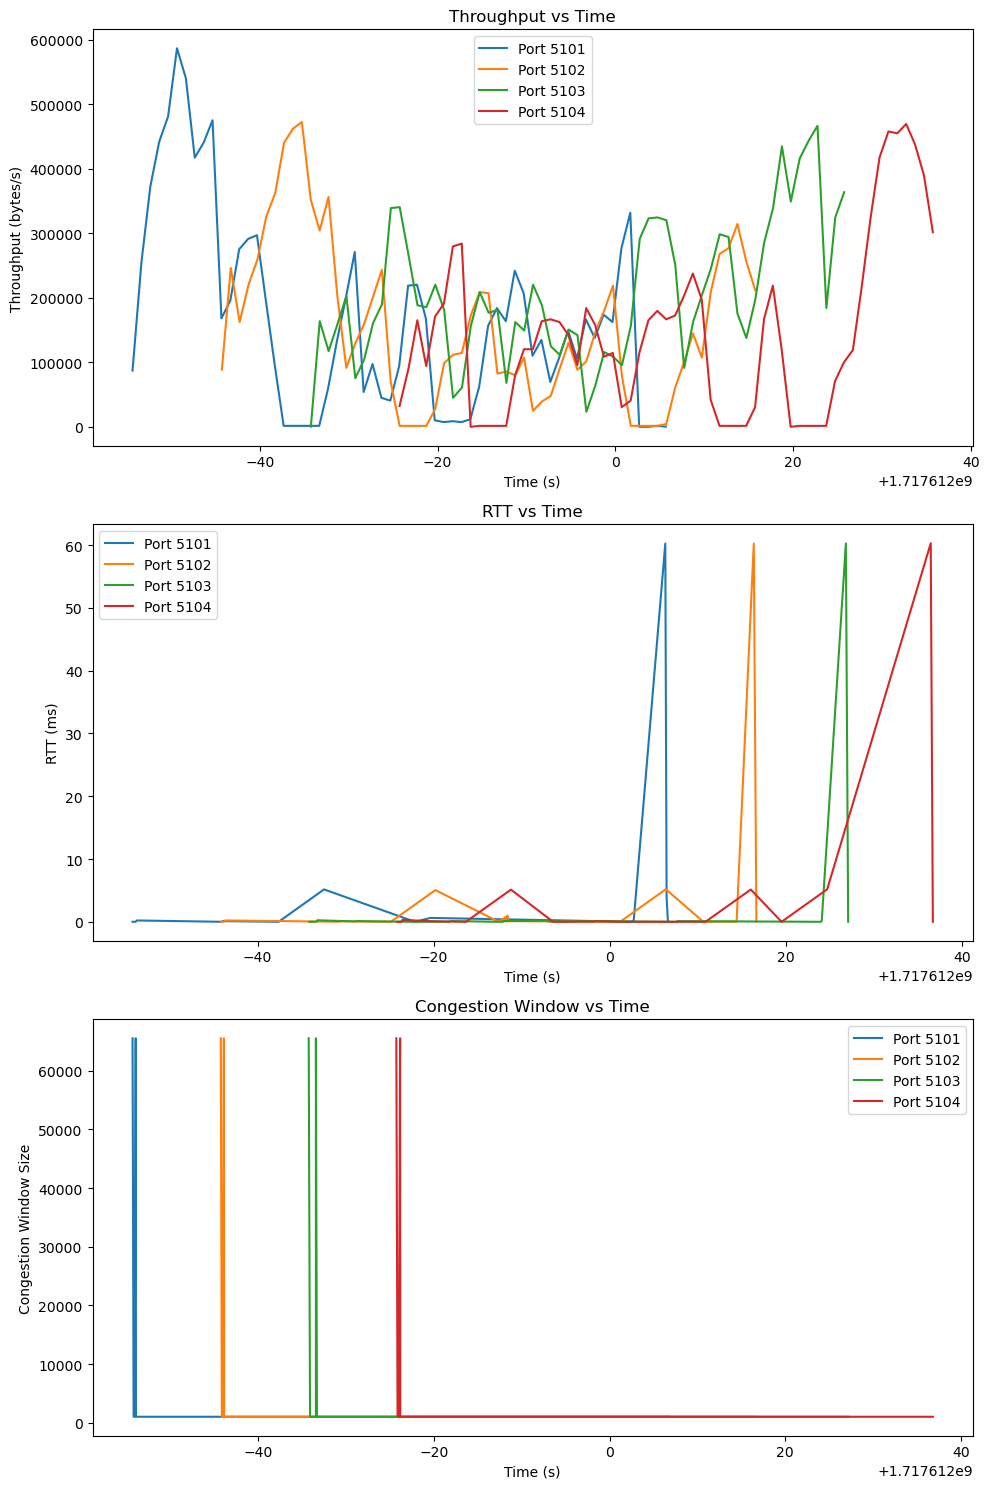

In [5]:
import dpkt
import socket
import matplotlib.pyplot as plt
from collections import defaultdict
import datetime

def parse_pcap(file_path, ports):
    data = defaultdict(list)
    
    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if isinstance(eth.data, dpkt.ip.IP):
                ip = eth.data
                if isinstance(ip.data, dpkt.tcp.TCP):
                    tcp = ip.data
                    src_port = tcp.sport
                    dst_port = tcp.dport
                    seq_num = tcp.seq
                    ack_num = tcp.ack
                    window_size = tcp.win
                    length = len(tcp.data)
                    
                    if dst_port in ports:
                        data[dst_port].append({
                            'timestamp': timestamp,
                            'src_port': src_port,
                            'dst_port': dst_port,
                            'seq_num': seq_num,
                            'ack_num': ack_num,
                            'window_size': window_size,
                            'length': length
                        })
    return data

def calculate_throughput(data, interval=1.0):
    throughput = defaultdict(list)
    
    for port, packets in data.items():
        packets.sort(key=lambda x: x['timestamp'])
        start_time = packets[0]['timestamp']
        current_interval = start_time
        
        bytes_transferred = 0
        
        for packet in packets:
            if packet['timestamp'] <= current_interval + interval:
                bytes_transferred += packet['length']
            else:
                throughput[port].append((current_interval, bytes_transferred / interval))
                current_interval += interval
                bytes_transferred = packet['length']
                
    return throughput

def calculate_rtt(data):
    rtt = defaultdict(list)
    sent_packets = {}
    
    for port, packets in data.items():
        for packet in packets:
            key = (packet['src_port'], packet['seq_num'])
            if key not in sent_packets:
                sent_packets[key] = packet['timestamp']
            else:
                rtt_value = packet['timestamp'] - sent_packets[key]
                rtt[port].append((packet['timestamp'], rtt_value))
                
    return rtt

def plot_data(throughput, rtt, window_sizes, ports):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    for port in ports:
        if port in throughput:
            x, y = zip(*throughput[port])
            axs[0].plot(x, y, label=f'Port {port}')
        if port in rtt:
            x, y = zip(*rtt[port])
            axs[1].plot(x, y, label=f'Port {port}')
        if port in window_sizes:
            x, y = zip(*window_sizes[port])
            axs[2].plot(x, y, label=f'Port {port}')
    
    axs[0].set_title('Throughput vs Time')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Throughput (bytes/s)')
    axs[0].legend()

    axs[1].set_title('RTT vs Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('RTT (ms)')
    axs[1].legend()

    axs[2].set_title('Congestion Window vs Time')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Congestion Window Size')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Main execution
file_path = pcap_file
ports = [5101, 5102, 5103, 5104]

# Parse pcap file
data = parse_pcap(file_path, ports)

# Calculate metrics
throughput = calculate_throughput(data)
rtt = calculate_rtt(data)

# Extract window sizes
window_sizes = {port: [(pkt['timestamp'], pkt['window_size']) for pkt in pkts] for port, pkts in data.items()}

# Plot the data
plot_data(throughput, rtt, window_sizes, ports)


In [6]:
throughput

defaultdict(list,
            {5101: [(1717611945.680567, 87082.0),
              (1717611946.680567, 254848.0),
              (1717611947.680567, 372136.0),
              (1717611948.680567, 441640.0),
              (1717611949.680567, 480736.0),
              (1717611950.680567, 586440.0),
              (1717611951.680567, 540104.0),
              (1717611952.680567, 417024.0),
              (1717611953.680567, 440192.0),
              (1717611954.680567, 474944.0),
              (1717611955.680567, 167968.0),
              (1717611956.680567, 195480.0),
              (1717611957.680567, 275120.0),
              (1717611958.680567, 291048.0),
              (1717611959.680567, 296840.0),
              (1717611960.680567, 195480.0),
              (1717611961.680567, 95568.0),
              (1717611962.680567, 1447.0),
              (1717611963.680567, 1448.0),
              (1717611964.680567, 1448.0),
              (1717611965.680567, 1448.0),
              (1717611966.680567, 1448.0)

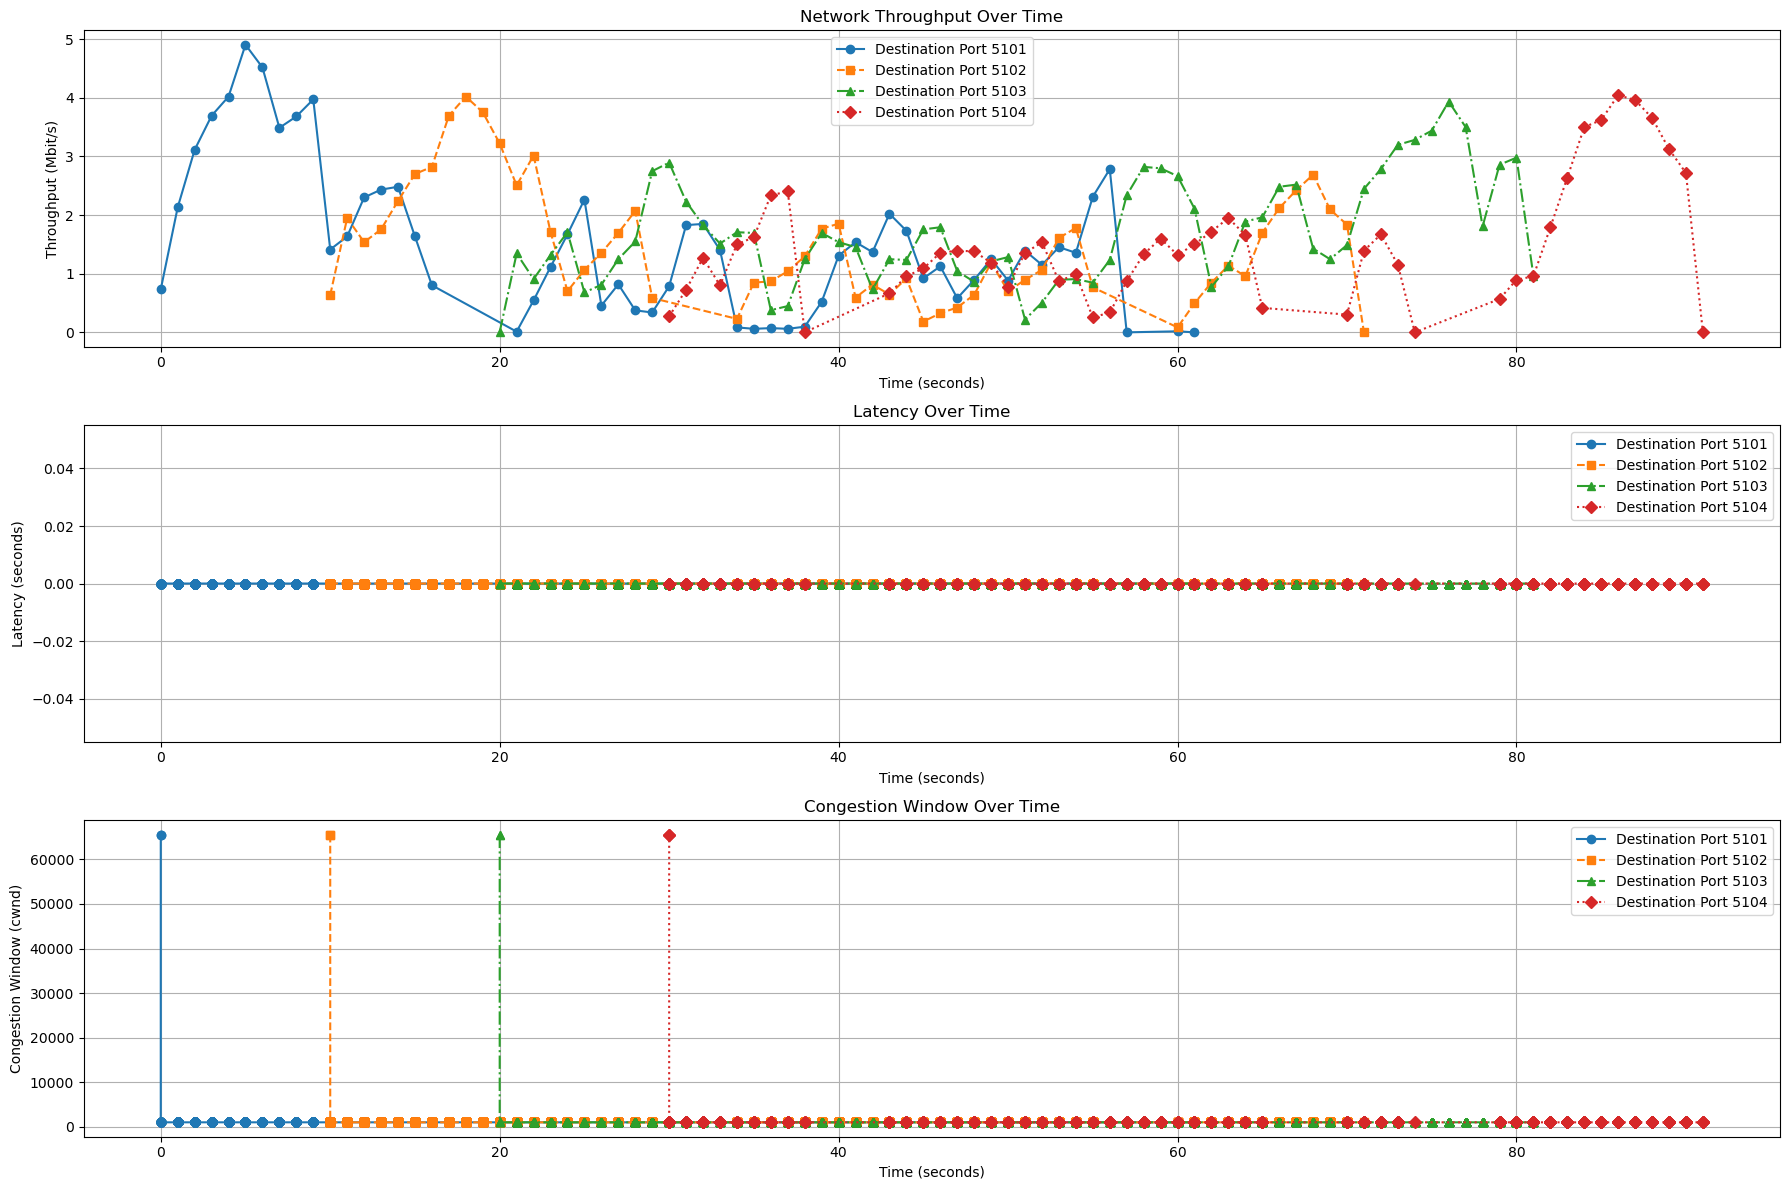

In [7]:
import dpkt
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

def read_pcap(file_path):
    throughput_per_second = {5101: {}, 5102: {}, 5103: {}, 5104: {}}
    latency_per_second = {5101: [], 5102: [], 5103: [], 5104: []}
    cwnd_per_second = {5101: [], 5102: [], 5103: [], 5104: []}
    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)

        prev_timestamp=0
        
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            if not isinstance(ip.data, dpkt.tcp.TCP):
                continue

            tcp = ip.data
            dest_port = tcp.dport
            if dest_port not in throughput_per_second:
                continue

            pkt_length = len(buf)
            
            if start_time is None:
                start_time = timestamp

            # Normalize the timestamp to start from 0
            normalized_time = int(timestamp - start_time)
            latencyper = int(timestamp - prev_timestamp)
            prev_timestamp=timestamp
            
            # Throughput calculation
            if normalized_time not in throughput_per_second[dest_port]:
                throughput_per_second[dest_port][normalized_time] = pkt_length
            else:
                throughput_per_second[dest_port][normalized_time] += pkt_length
            
            # Latency calculation (assuming we have access to sequence/acknowledgment numbers)
            if tcp.flags & dpkt.tcp.TH_ACK:
                latency_per_second[dest_port].append((normalized_time, latencyper))
            
            # Congestion window approximation
            cwnd_per_second[dest_port].append((normalized_time, tcp.win))
    
    return throughput_per_second, latency_per_second, cwnd_per_second

def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000

def plot_metrics(throughput, latency, cwnd):
    plt.figure(figsize=(18, 12))

    # Plot throughput
    plt.subplot(3, 1, 1)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D']
    
    for i, (port, data) in enumerate(throughput.items()):
        sorted_throughput = sorted(data.items())
        times = [item[0] for item in sorted_throughput]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_throughput]
        
        plt.plot(times, mbits_transferred, label=f'Destination Port {port}',
                 color=colors[i], linestyle=line_styles[i], marker=markers[i])
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (Mbit/s)')
    plt.title('Network Throughput Over Time')
    plt.legend()
    plt.grid()

    # Plot latency
    plt.subplot(3, 1, 2)
    for i, (port, data) in enumerate(latency.items()):
        times, latencies = zip(*data) if data else ([], [])
        plt.plot(times, latencies, label=f'Destination Port {port}',
                 color=colors[i], linestyle=line_styles[i], marker=markers[i])
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Latency (seconds)')
    plt.title('Latency Over Time')
    plt.legend()
    plt.grid()

    # Plot congestion window
    plt.subplot(3, 1, 3)
    for i, (port, data) in enumerate(cwnd.items()):
        times, cwnds = zip(*data) if data else ([], [])
        plt.plot(times, cwnds, label=f'Destination Port {port}',
                 color=colors[i], linestyle=line_styles[i], marker=markers[i])
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Congestion Window (cwnd)')
    plt.title('Congestion Window Over Time')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    pcap_file = pcap_file
    throughput_per_second, latency_per_second, cwnd_per_second = read_pcap(pcap_file)
    plot_metrics(throughput_per_second, latency_per_second, cwnd_per_second)


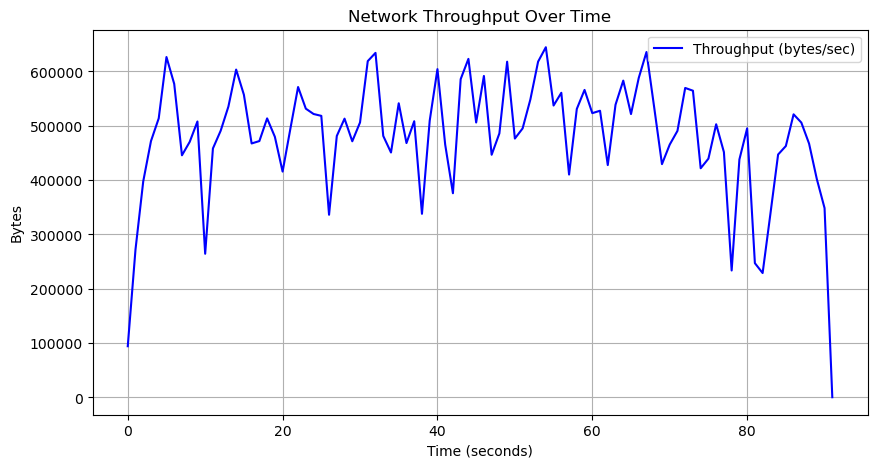

In [8]:
import dpkt
import datetime
import matplotlib.pyplot as plt

def read_pcap(file_path):
    throughput_per_second = {}
    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            pkt_length = len(buf)
            
            if start_time is None:
                start_time = timestamp

            # Normalize the timestamp to start from 0
            normalized_time = int(timestamp - start_time)
            
            if normalized_time not in throughput_per_second:
                throughput_per_second[normalized_time] = pkt_length
            else:
                throughput_per_second[normalized_time] += pkt_length
    
    return throughput_per_second

def plot_throughput(throughput):
    # Sort throughput dictionary by time
    sorted_throughput = sorted(throughput.items())
    
    times = [item[0] for item in sorted_throughput]
    bytes_transferred = [item[1] for item in sorted_throughput]
    
    plt.figure(figsize=(10, 5))
    plt.plot(times, bytes_transferred, label='Throughput (bytes/sec)', color='blue')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Bytes')
    plt.title('Network Throughput Over Time')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    pcap_file = pcap_file
    throughput_per_second = read_pcap(pcap_file)
    plot_throughput(throughput_per_second)



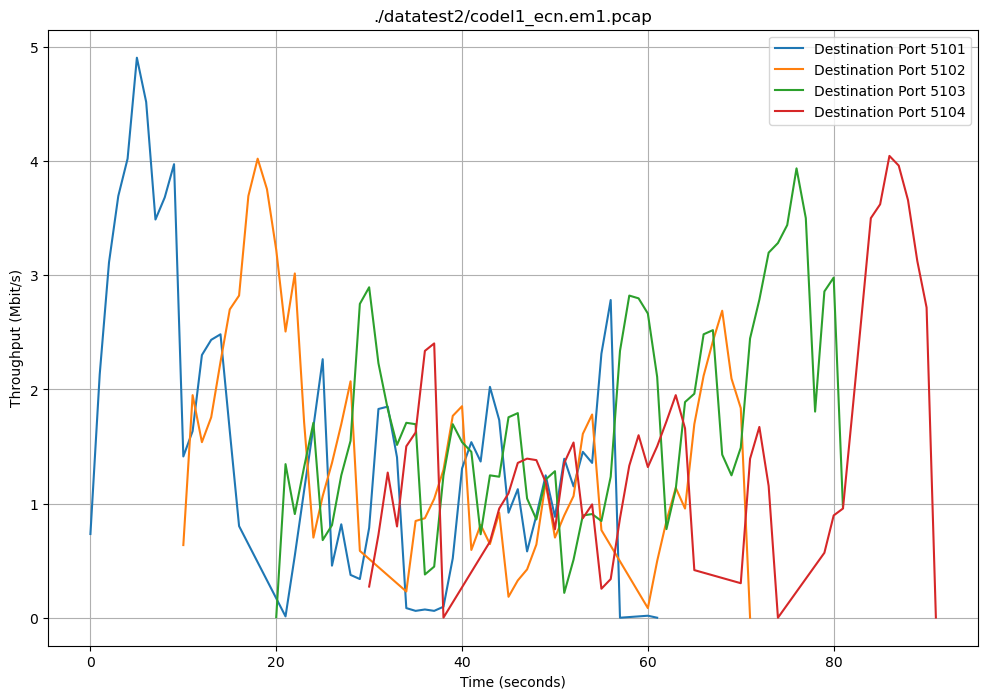

In [9]:
import dpkt
import datetime
import matplotlib.pyplot as plt

def read_pcap(file_path):
    throughput_per_second = {5101: {}, 5102: {}, 5103: {}, 5104: {}}
    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            if not isinstance(ip.data, dpkt.tcp.TCP):
                continue

            tcp = ip.data
            dest_port = tcp.dport
            if dest_port not in throughput_per_second:
                continue

            pkt_length = len(buf)
            
            if start_time is None:
                start_time = timestamp

            # Normalize the timestamp to start from 0
            normalized_time = int(timestamp - start_time)
            
            if normalized_time not in throughput_per_second[dest_port]:
                throughput_per_second[dest_port][normalized_time] = pkt_length
            else:
                throughput_per_second[dest_port][normalized_time] += pkt_length
    
    return throughput_per_second

def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000

def plot_throughput(throughput):
    plt.figure(figsize=(12, 8))
    
    for port, data in throughput.items():
        # Sort throughput dictionary by time
        sorted_throughput = sorted(data.items())
        
        times = [item[0] for item in sorted_throughput]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_throughput]
        
        plt.plot(times, mbits_transferred, label=f'Destination Port {port}')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (Mbit/s)')
    plt.title(pcap_file)
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    pcap_file = pcap_file
    throughput_per_second = read_pcap(pcap_file)
    plot_throughput(throughput_per_second)


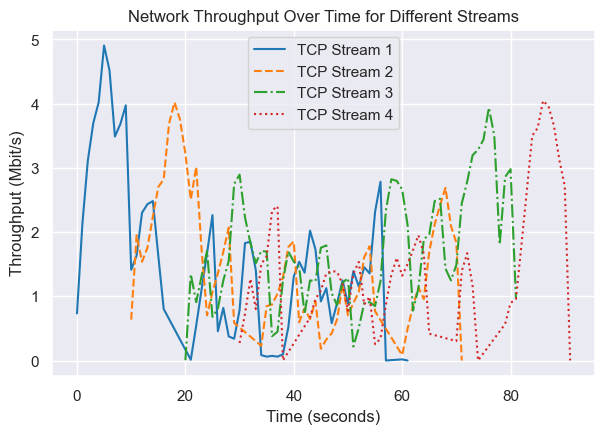

In [10]:
import dpkt
import datetime
import matplotlib.pyplot as plt

def read_pcap(file_path):
    throughput_per_second = {5101: {}, 5102: {}, 5103: {}, 5104: {}}
    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            if not isinstance(ip.data, dpkt.tcp.TCP):
                continue

            tcp = ip.data
            dest_port = tcp.dport
            if dest_port not in throughput_per_second:
                continue

            pkt_length = len(buf)
            
            if start_time is None:
                start_time = timestamp

            # Normalize the timestamp to start from 0
            normalized_time = int(timestamp - start_time)
            
            if normalized_time not in throughput_per_second[dest_port]:
                throughput_per_second[dest_port][normalized_time] = pkt_length
            else:
                throughput_per_second[dest_port][normalized_time] += pkt_length
    
    return throughput_per_second

def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000

def plot_throughput(throughput):
    plt.figure(figsize=(7, 4.5))  # Set the figure size to fit within the column width
    sns.set(style="darkgrid")  # Set the style to darkgrid
    
    # Darker color-blind-friendly palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    # Different line styles and markers
    line_styles = ['-', '--', '-.', ':']
    #line_styles = ['-', '-', '-', '-']
    markers = ['o', 's', '^', 'D']
    #markers = ['^', '^', '^', '^']

    for i, (port, data) in enumerate(throughput.items()):
        # Sort throughput dictionary by time
        sorted_throughput = sorted(data.items())
        
        times = [item[0] for item in sorted_throughput]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_throughput]
        
        plt.plot(times, mbits_transferred, label=f'TCP Stream {i+1}',
                 color=colors[i], linestyle=line_styles[i])
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (Mbit/s)')
    plt.title('Network Throughput Over Time for Different Streams')
    plt.legend()
   
    plt.show()


pcap_file = pcap_file
throughput_per_second = read_pcap(pcap_file)
plot_throughput(throughput_per_second)


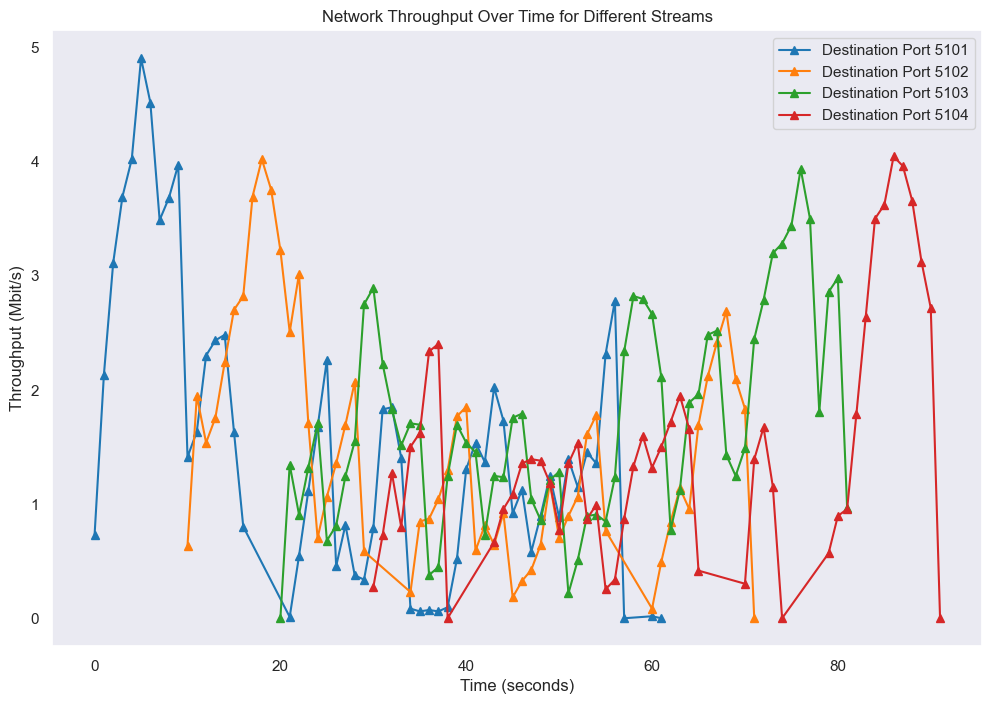

In [11]:
import dpkt
import datetime
import matplotlib.pyplot as plt

def read_pcap(file_path):
    throughput_per_second = {5101: {}, 5102: {}, 5103: {}, 5104: {}}
    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            if not isinstance(ip.data, dpkt.tcp.TCP):
                continue

            tcp = ip.data
            dest_port = tcp.dport
            if dest_port not in throughput_per_second:
                continue

            pkt_length = len(buf)
            
            if start_time is None:
                start_time = timestamp

            # Normalize the timestamp to start from 0
            normalized_time = int(timestamp - start_time)
            
            if normalized_time not in throughput_per_second[dest_port]:
                throughput_per_second[dest_port][normalized_time] = pkt_length
            else:
                throughput_per_second[dest_port][normalized_time] += pkt_length
    
    return throughput_per_second

def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000

def plot_throughput(throughput):
    plt.figure(figsize=(12, 8))
    
    # Darker color-blind-friendly palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    # Different line styles and markers
    line_styles = ['-', '--', '-.', ':']
    line_styles = ['-', '-', '-', '-']
    markers = ['o', 's', '^', 'D']
    markers = ['^', '^', '^', '^']

    for i, (port, data) in enumerate(throughput.items()):
        # Sort throughput dictionary by time
        sorted_throughput = sorted(data.items())
        
        times = [item[0] for item in sorted_throughput]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_throughput]
        
        plt.plot(times, mbits_transferred, label=f'Destination Port {port}',
                 color=colors[i], linestyle=line_styles[i], marker=markers[i])
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (Mbit/s)')
    plt.title('Network Throughput Over Time for Different Streams')
    plt.legend()
    plt.grid()
    plt.show()


pcap_file = pcap_file
throughput_per_second = read_pcap(pcap_file)
plot_throughput(throughput_per_second)


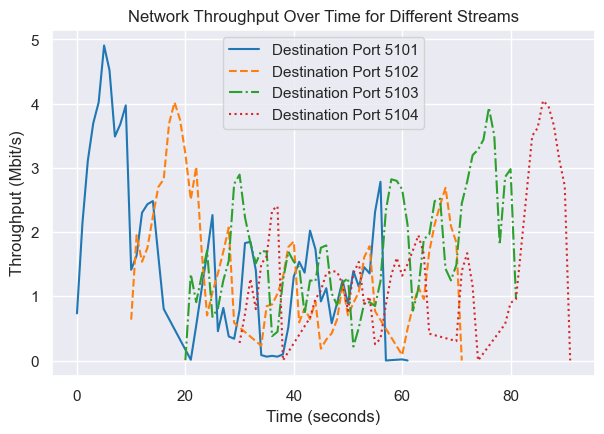

In [12]:
import dpkt
import datetime
import matplotlib.pyplot as plt

def read_pcap(file_path):
    throughput_per_second = {5101: {}, 5102: {}, 5103: {}, 5104: {}}
    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            if not isinstance(ip.data, dpkt.tcp.TCP):
                continue

            tcp = ip.data
            dest_port = tcp.dport
            if dest_port not in throughput_per_second:
                continue

            pkt_length = len(buf)
            
            if start_time is None:
                start_time = timestamp

            # Normalize the timestamp to start from 0
            normalized_time = int(timestamp - start_time)
            
            if normalized_time not in throughput_per_second[dest_port]:
                throughput_per_second[dest_port][normalized_time] = pkt_length
            else:
                throughput_per_second[dest_port][normalized_time] += pkt_length
    
    return throughput_per_second

def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000

def plot_throughput(throughput):
    plt.figure(figsize=(7, 4.5))  # Set the figure size to fit within the column width
    sns.set(style="darkgrid")  # Set the style to darkgrid
    
    # Darker color-blind-friendly palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    # Different line styles and markers
    line_styles = ['-', '--', '-.', ':']
    #line_styles = ['-', '-', '-', '-']
    markers = ['o', 's', '^', 'D']
    #markers = ['^', '^', '^', '^']

    for i, (port, data) in enumerate(throughput.items()):
        # Sort throughput dictionary by time
        sorted_throughput = sorted(data.items())
        
        times = [item[0] for item in sorted_throughput]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_throughput]
        
        plt.plot(times, mbits_transferred, label=f'Destination Port {port}',
                 color=colors[i], linestyle=line_styles[i])
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (Mbit/s)')
    plt.title('Network Throughput Over Time for Different Streams')
    plt.legend()
   
    plt.show()


pcap_file = pcap_file
throughput_per_second = read_pcap(pcap_file)
plot_throughput(throughput_per_second)


In [13]:
# import dpkt
# import socket


# # Define the maximum port and window size
# def get_tcp_window_scale_option(tcp_options):
#     for opt in dpkt.tcp.parse_opts(tcp_options):
#         if opt[0] == dpkt.tcp.TCP_OPT_WSCALE:
#             scale_factor = int.from_bytes(opt[1], byteorder='big')
#             return 2 ** scale_factor
#     return 1  # Default scale if option is not present


# def analysis_pcap_tcp(pcap_file):
#     with open(pcap_file, 'rb') as f:
#         pcap = dpkt.pcap.Reader(f)
#         tcp_flows = {}
#         sender_ip = None

#         for timestamp, buf in pcap:
#             try:
#                 # Parse the packet
#                 eth = dpkt.ethernet.Ethernet(buf)
#                 # Ensure the packet is an IP packet
#                 if not isinstance(eth.data, dpkt.ip.IP):
#                     continue
#                 ip = eth.data
#                 # Ensure the packet is a TCP packet
#                 if not isinstance(ip.data, dpkt.tcp.TCP):
#                     continue
#                 tcp = ip.data

#                 # Extract relevant information from the packet
#                 src_ip = socket.inet_ntoa(ip.src)
#                 dst_ip = socket.inet_ntoa(ip.dst)

#                 # Determine if this is the first packet in the conversation to set the sender
#                 if sender_ip is None and (tcp.flags & dpkt.tcp.TH_SYN):
#                     sender_ip = src_ip  # The sender is the one who sends the first SYN
#                 if sender_ip != dst_ip and sender_ip != src_ip and (tcp.flags & dpkt.tcp.TH_SYN):
#                     sender_ip = src_ip  # The sender is the one who sends the first SYN
#                 # If this packet is not from the sender, ignore it
#                 if src_ip != sender_ip:
#                     continue

#                 # Extract the source and destination ports
#                 src_port = tcp.sport
#                 dst_port = tcp.dport

#                 # Sort IP addresses and ports to identify flows uniquely irrespective of direction.
#                 flow_id = (src_ip, src_port, dst_ip, dst_port)

#                 # Ensure flow is initialized for any TCP packet, adjusting the logic accordingly.
#                 if flow_id not in tcp_flows:
#                     tcp_flows[flow_id] = {
#                         'start_time': None, 'end_time': timestamp, 'data_bytes': 0,
#                         'transactions': [], 'handshake_complete': False, 'packet_count': 0, 
#                         'flow_tuple': flow_id, 'window_scale': 1, 'syn': False, 'fin': False,
#                         'initial_rtt': None, 'rtt_estimation': None, 'cwnd_packets': [], 
#                         'last_packet_time': None, 'ack_freq': {}, 'seq_numbers': {},   
#                         'triple_dup_acks': 0, 'timeouts': 0, 'retransmissions': -1, 'seen_seqs': {},
#                     }

#                 # Get the flow object
#                 flow = tcp_flows[flow_id]
#                 flow['end_time'] = timestamp

#                 # Update the flow information
#                 if flow['start_time'] is None and tcp.flags & dpkt.tcp.TH_SYN:
#                     flow['start_time'] = timestamp  # Set the start time of the flow
#                     flow['window_scale'] = get_tcp_window_scale_option(tcp.opts) # Get the window scale option
#                 if flow['start_time'] is not None:
#                     flow['data_bytes'] += len(tcp)
#                     flow['packet_count'] += 1
                    
#                 # Check for handshake completion
#                 if tcp.flags & dpkt.tcp.TH_SYN and not tcp.flags & dpkt.tcp.TH_ACK:
#                     flow['syn'] = True
#                 if tcp.flags & dpkt.tcp.TH_ACK and flow['syn'] and not flow['handshake_complete']:
#                     flow['handshake_complete'] = True

#                 # Check for flow termination
#                 if tcp.flags & dpkt.tcp.TH_FIN | dpkt.tcp.TH_RST:
#                     flow['fin'] = True
                
                
#                 # Check for data packets
#                 if flow['handshake_complete'] and len(tcp.data) > 0:
#                     # Add the transaction to the flow if one of first 2
#                     if len(flow['transactions']) < 2:
#                         flow['transactions'].append((tcp.seq, tcp.ack, tcp.win * flow['window_scale']))

#                 # Adjusting logic to capture initial RTT and counting packets per RTT
#                 if tcp.flags & dpkt.tcp.TH_SYN and not flow['initial_rtt']:
#                     flow['last_packet_time'] = timestamp  # Mark the time of the SYN packet
#                 elif tcp.flags & dpkt.tcp.TH_ACK and flow['syn'] and not flow['initial_rtt']:
#                     # Assuming this ACK is part of the handshake completion
#                     flow['initial_rtt'] = timestamp - flow['last_packet_time']  # Initial RTT estimation
#                     flow['rtt_estimation'] = flow['initial_rtt']  # Storing initial RTT as the estimate
#                     flow['last_packet_time'] = timestamp  # Resetting for packet counting

#                 # Logic to count packets per estimated RTT
#                 if flow['initial_rtt']:
#                     time_since_last_packet = timestamp - flow['last_packet_time']
#                     if time_since_last_packet < flow['rtt_estimation']:
#                         # Still within the same RTT, count the packet
#                         if len(flow['cwnd_packets']) == 0:
#                             flow['cwnd_packets'].append(1)  # Starting the first count
#                         else:
#                             flow['cwnd_packets'][-1] += 1  # Increment current RTT's packet count 
#                             pass
#                     else:
#                         # New RTT period, reset packet count
#                         if len(flow['cwnd_packets']) < 4:  # Only if we need more CWND sizes
#                             flow['cwnd_packets'].append(1)  # Start counting for a new CWND size
#                         flow['last_packet_time'] = timestamp  # Resetting for next RTT counting

#                 if (tcp.flags & dpkt.tcp.TH_ACK) and not (tcp.flags & dpkt.tcp.TH_SYN):
#                     ack = tcp.ack
#                     # Track ACKs for triple duplicate detection
#                     if ack not in flow['ack_freq']:
#                         flow['ack_freq'][ack] = 1
#                     else:
#                         flow['ack_freq'][ack] += 1
#                         current_ack_freq = flow['ack_freq'][ack]
#                         if current_ack_freq == 4:  # Triple duplicate ACK detected
#                             flow['triple_dup_acks'] += 1

#                 # Track sequence numbers to identify retransmissions
#                 if tcp.seq not in flow['seq_numbers']:
#                     flow['seq_numbers'][tcp.seq] = timestamp
#                 else:
#                     # Check if the packet is a retransmission
#                     if timestamp - flow['seq_numbers'][tcp.seq] > 2 * flow['rtt_estimation']: # Timeout threshold
#                         flow['timeouts'] += 1

#                 # Track sequence numbers to detect retransmissions
#                 seq = tcp.seq
#                 if flow['handshake_complete'] and seq in flow['seen_seqs'] and flow['seen_seqs'][seq] is True:
#                     # If the sequence number has been seen before, it's a retransmission
#                     flow['retransmissions'] += 1
#                     flow['seen_seqs'][seq] = False
#                 elif flow['handshake_complete']:
#                     # Otherwise, mark the sequence number as seen
#                     flow['seen_seqs'][seq] = True

#             except Exception as e:
#                 # Print the error and continue to the next packet
#                 print(f"Error processing packet: {e}")

#     # Output results
#     print(f"\nNumber of TCP flows initiated from the sender: {len(tcp_flows)}\n")
#     flow_count = 1
#     for flow_id, data in tcp_flows.items():
#         print(f"Flow {flow_count}:")
#         flow_count += 1
#         print(f"  Source IP: {data['flow_tuple'][0]}, Source Port: {data['flow_tuple'][1]} -> Destination IP: {data['flow_tuple'][2]}, Destination Port: {data['flow_tuple'][3]}")
#         for i, transaction in enumerate(data['transactions'], 1):
#             seq_num, ack_num, rec_win_size = transaction
#             print(f"  Transaction {i}: Seq Num: {seq_num}, Ack Num: {ack_num}, Rec Win Size: {rec_win_size}")
#         if 'end_time' in data and data['end_time'] is not None:
#             duration = data['end_time'] - data['start_time']
#             throughput = data['data_bytes'] / duration if duration > 0 else 0
#             print(f"  Sender Throughput: {throughput} bytes/sec")
#             print(f"  == ({data['data_bytes']} bytes sent in {data['end_time'] - data['start_time']} seconds)")
#             print(f"  First 3 Congestion Window Sizes: {data['cwnd_packets'][0:3]}")
#             print(f"  Retransmissions due to Triple Duplicate ACKs: {data['retransmissions'] - data['timeouts']}")
#             print(f"  Retransmissions due to Timeouts: {data['timeouts']}")
#         else:
#             print("  Incomplete flow.")
#         print()


# analysis_pcap_tcp(pcap_file)